# 🎯 Agent学习 - 第一阶段：基础概念与简单LLM调用

## 📚 学习目标

在这个Notebook中，你将学习：
- Agent的核心概念和三大能力
- 如何使用LLM API进行对话
- 记忆管理的重要性
- 滑动窗口策略的实现

## 🚀 开始之前

请先确保：
1. 已安装所需依赖
2. 配置了API密钥
3. 理解基本的Python概念

## 🔧 环境配置

In [20]:
# 安装必要包（如未安装可取消注释）
# !pip install openai python-dotenv

import os
import dotenv
from openai import OpenAI
import json
from datetime import datetime

# 加载.env文件中的环境变量
dotenv.load_dotenv()

# 获取环境变量
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")
model = (
    os.getenv("MODEL_NAME")
    or os.getenv("OPENAI_MODEL")
    or "gpt-3.5-turbo"
)

print("🔍 检查环境配置...\n")
if api_key:
    print("API Key: ✅ 已配置")
else:
    print("API Key: ❌ 未配置，请在.env中填写 OPENAI_API_KEY")

print(f"Base URL: {base_url or 'https://api.openai.com/v1'}")
print(f"Model: {model}")


🔍 检查环境配置...

API Key: ✅ 已配置
Base URL: https://api.chatanywhere.tech/v1
Model: gpt-3.5-turbo


## 📖 核心概念回顾

### 什么是AI Agent？

Agent具备三大核心能力：
1. **环境感知**：获取外部信息
2. **自主决策**：将复杂任务拆解为可执行步骤
3. **执行反馈**：调用工具完成操作，根据结果调整策略

### Agent基础架构
```
用户需求 → 感知模块 → 决策模块 → 执行模块 → 反馈模块 → 输出结果
```

## 🤖 1. 简单对话助手实现

让我们从最基础的对话助手开始，理解LLM API的基本使用方法。

In [ ]:
# 定义SimpleChatAgent类。class用于定义类，后面跟类名和冒号。
class SimpleChatAgent:
    """
    最简单的对话助手
    每次对话都是独立的，没有记忆功能
    """

    # 定义构造方法__init__，初始化SimpleChatAgent实例
    def __init__(self):
        """初始化客户端"""
        # 使用OpenAI类实例化API客户端（需要api_key和base_url参数）
        self.client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),          # 从环境变量获取API密钥
            base_url=os.getenv("OPENAI_BASE_URL")         # 从环境变量获取Base URL
        )
        # 记录对话轮数的属性，初始为0
        self.conversation_count = 0

    # 定义chat方法，处理一次对话
    def chat(self, message, system_prompt="你是一个友好的助手"):
        """
        进行对话
        Args:
            message (str): 用户消息
            system_prompt (str): 系统提示词
        Returns:
            str: 助手回复
        """
        try:
            # 对话次数加1
            self.conversation_count += 1
            # 打印当前对话编号，f-string格式化字符串
            print(f"\n--- 对话 #{self.conversation_count} ---")
            # 打印用户输入内容
            print(f"用户: {message}")

            # 获取当前时间作为对话起始，用于计时
            start_time = datetime.now()
            # 调用OpenAI API，生成助手回复。参数包含模型、消息、采样温度等
            response = self.client.chat.completions.create(
                model=os.getenv("MODEL_NAME", "qwen-max"),       # 从环境变量读取模型名，默认qwen-max
                messages=[
                    {"role": "system", "content": system_prompt}, # 系统指令
                    {"role": "user", "content": message}          # 用户问题
                ],
                temperature=0.3,                                  # 设置temperature，决定回复多样性
                max_tokens=500                                    # 设置最大token数
            )
            # 获取对话结束时间
            end_time = datetime.now()

            # 取出助手回复内容
            assistant_msg = response.choices[0].message.content
            # 统计token使用
            tokens_used = response.usage.total_tokens
            # 计算响应耗时（秒）
            response_time = (end_time - start_time).total_seconds()

            # 打印助手回复和统计信息
            print(f"助手: {assistant_msg}")
            print(f"📊 Token使用: {tokens_used}, 响应时间: {response_time:.2f}秒")

            # 返回包含回复、token数、响应时间的字典
            return {
                "response": assistant_msg,
                "tokens_used": tokens_used,
                "response_time": response_time
            }
        except Exception as e:
            # 捕获异常，生成错误消息并打印
            error_msg = f"抱歉，出错了：{str(e)}"
            print(f"❌ {error_msg}")
            # 返回包含错误信息的字典
            return {"error": error_msg}

# 创建SimpleChatAgent实例，赋值给simple_agent变量
simple_agent = SimpleChatAgent()
# 打印助手已创建信息
print("✅ 简单对话助手已创建")

✅ 简单对话助手已创建


### 🧪 测试简单对话助手

In [27]:
# 测试对话序列 - 观察无记忆的特点
test_conversations = [
    "你好！请记住我的名字，我叫小明。",
    "我是一名程序员，住在上海。",
    "你记得我叫什么名字吗？",
    "我住在哪个城市？",
    "我的职业是什么？"
]

print("🤖 简单对话助手测试")
print("=" * 50)
print("观察：每个问题都是独立的，助手无法记住之前的对话内容\n")

results = []
for i, question in enumerate(test_conversations, 1):
    result = simple_agent.chat(question)
    results.append(result)
    print("-" * 40)

print("\n📊 测试总结:")
total_tokens = sum(r.get("tokens_used", 0) for r in results if "tokens_used" in r)
avg_time = sum(r.get("response_time", 0) for r in results if "response_time" in r) / len(results)
print(f"总Token使用: {total_tokens}")
print(f"平均响应时间: {avg_time:.2f}秒")
print(f"对话次数: {simple_agent.conversation_count}")

🤖 简单对话助手测试
观察：每个问题都是独立的，助手无法记住之前的对话内容


--- 对话 #6 ---
用户: 你好！请记住我的名字，我叫小明。
助手: 你好，小明！很高兴认识你！有什么我可以帮助你的吗？
📊 Token使用: 47, 响应时间: 1.06秒
----------------------------------------

--- 对话 #7 ---
用户: 我是一名程序员，住在上海。
助手: 很高兴认识你！作为一名程序员，你主要从事什么领域的开发呢？是前端、后端还是其他方面？如果你有任何技术问题或者想讨论的主题，随时可以告诉我！
📊 Token使用: 77, 响应时间: 1.57秒
----------------------------------------

--- 对话 #8 ---
用户: 你记得我叫什么名字吗？
助手: 抱歉，我无法记住个人信息或之前的对话内容。请问我可以如何帮助你呢？
📊 Token使用: 50, 响应时间: 0.74秒
----------------------------------------

--- 对话 #9 ---
用户: 我住在哪个城市？
助手: 抱歉，我无法知道您住在哪个城市。如果您愿意，可以告诉我您所在的城市，我会尽力为您提供相关信息或帮助！
📊 Token使用: 57, 响应时间: 1.17秒
----------------------------------------

--- 对话 #10 ---
用户: 我的职业是什么？
助手: 我无法直接知道你的职业，但我可以帮助你探索或讨论不同的职业选择。如果你愿意，可以告诉我一些关于你的兴趣、技能或经历的信息，我可以帮助你找到适合的职业方向。
📊 Token使用: 67, 响应时间: 1.35秒
----------------------------------------

📊 测试总结:
总Token使用: 298
平均响应时间: 1.18秒
对话次数: 10


## 🧠 2. 记忆管理：滑动窗口策略

现在让我们添加记忆功能，这是Agent最重要的能力之一。

In [32]:
# 定义 SlidingWindowMemory 类，实现滑动窗口记忆功能
class SlidingWindowMemory:
    """
    滑动窗口记忆管理
    只保留最近N轮对话，避免上下文过长
    """

    # 构造方法，初始化 SlidingWindowMemory 实例
    def __init__(self, window_size=5):
        """
        初始化记忆管理器
        Args:
            window_size (int): 保留的对话轮数
        """
        # 实例属性 window_size，用于记录窗口大小，即需要保留的最近对话轮数
        self.window_size = window_size
        # 实例属性 context，保存对话上下文，是一个字典组成的列表。第一条为 system 消息（固定指令）。
        self.context = [
            {"role": "system", "content": "你是一个有记忆的友好助手，能够记住之前的对话内容。"}
        ]
        # 实例属性 total_conversations，计数对话次数，可扩展使用，目前未使用
        self.total_conversations = 0

    # 定义 update 方法，更新上下文（记忆）
    def update(self, role, content):
        """更新对话上下文"""
        # 将新的消息（字典）添加到 context 列表末尾
        self.context.append({"role": role, "content": content})

        # 为什么是 window_size*2+1？
        # 每一轮对话包含用户(user)和助手(assistant)各一条消息，所以一轮是2条，window_size 表示要保留的最近N轮全部内容，所以最多有 window_size*2 条消息；
        # 此外，system 消息在最前面还要额外占一条，所以最大消息数为 window_size*2+1。
        max_messages = self.window_size * 2 + 1

        # 如果 context 消息超过最大长度，循环删除最早的 user/assistant 消息（system 保留）
        while len(self.context) > max_messages:
            # 详细说明：
            # 为什么是 window_size*2+1？因为每轮对话包含 1 条 user 和 1 条 assistant 消息，所以 window_size 轮就是 2*window_size 条消息；
            # 再加上最前面的 system 消息，共 window_size*2+1 条；
            # 下面代码：下标0为system，下标1是最早的一条 user 或 assistant，要把超出的最早一对(user+assistant)删除以保证只保留最近N轮
            # 只要长度超限就循环弹出最早的一对 user + assistant
            while len(self.context) > max_messages:
                # 弹出最早一条 user 消息（下标1）
                if self.context[1]["role"] == "user":
                    self.context.pop(1)
                # 如果下一个还是 assistant，则也弹出，保证 user-assistant 成对弹出
                if len(self.context) > 1 and self.context[1]["role"] == "assistant":
                    self.context.pop(1)

    # get_context 方法，返回当前上下文的副本（防止外部直接修改 context）
    def get_context(self):
        """获取当前上下文"""
        return self.context.copy()

    # get_stats 方法，返回记忆的统计信息
    def get_stats(self):
        """获取记忆统计信息"""
        # 计算 context 中 user 消息个数
        user_msgs = sum(1 for msg in self.context if msg["role"] == "user")
        # 计算 assistant 消息个数
        assistant_msgs = sum(1 for msg in self.context if msg["role"] == "assistant")
        # 估算 token 数，这里用内容文本长度简单代替，实际token须llm端计数
        total_tokens = sum(len(msg["content"]) for msg in self.context)

        # 返回一个字典，包含当前上下文消息条数及其他统计信息
        return {
            "total_messages": len(self.context),
            "user_messages": user_msgs,
            "assistant_messages": assistant_msgs,
            "estimated_tokens": total_tokens,
            "window_size": self.window_size
        }

    # visualize_context 方法，打印当前上下文内容，便于调试和观察
    def visualize_context(self):
        """可视化当前上下文"""
        print("\n📋 当前记忆上下文:")
        # 枚举循环上下文，每条注明索引编号和角色
        for i, msg in enumerate(self.context):
            # 定义角色对应的小图标（emoji）
            role_emoji = {"system": "🔧", "user": "👤", "assistant": "🤖"}
            # 内容只显示前50个字符（过长则加省略号）
            content_preview = msg["content"][:50] + "..." if len(msg["content"]) > 50 else msg["content"]
            print(f"  {i}. {role_emoji.get(msg['role'], '❓')} {content_preview}")

# 测试滑动窗口记忆管理器功能
print("🧠 测试滑动窗口记忆管理器")
# 创建 SlidingWindowMemory 类的实例，窗口大小为3轮
memory = SlidingWindowMemory(window_size=3)
print("✅ 记忆管理器已创建")
# 可视化输出当前上下文内容
memory.visualize_context()

🧠 测试滑动窗口记忆管理器
✅ 记忆管理器已创建

📋 当前记忆上下文:
  0. 🔧 你是一个有记忆的友好助手，能够记住之前的对话内容。


In [37]:
# 定义 MemoryChatAgent 类，带有记忆能力的对话助手，应用滑动窗口机制
class MemoryChatAgent:
    """
    带记忆功能的对话助手
    使用滑动窗口策略管理对话历史
    """

    # 构造函数，初始化对话助手对象
    def __init__(self, window_size=5):
        # 创建 OpenAI 客户端对象，语法: 对象 = 类名(参数1=值1, 参数2=值2)
        self.client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),      # 从环境变量中读取API密钥
            base_url=os.getenv("OPENAI_BASE_URL")     # 从环境变量中读取API接口基础URL
        )
        # 初始化滑动窗口记忆，window_size为窗口大小
        self.memory = SlidingWindowMemory(window_size)
        # 对话轮数计数，初始为0，用于统计和输出
        self.conversation_count = 0

    # chat 方法，用于与助手进行一次对话（含记忆管理）
    def chat(self, message):
        """进行对话，自动管理记忆"""
        try:
            # 语法：变量 += 1 实现自增；每轮对话计数加一
            self.conversation_count += 1
            # 格式化字符串输出对话轮标识
            print(f"\n--- 对话 #{self.conversation_count} ---")
            # 输出用户消息，f字符串插入变量
            print(f"用户: {message}")

            # 调用 memory.update 方法，将用户消息加入当前上下文记忆
            self.memory.update("user", message)

            # 获取完整上下文，作为模型输入; 此处context为消息列表
            context = self.memory.get_context()

            # 记录调用API的起始时间，语法：now = datetime.now()
            start_time = datetime.now()
            # 发送请求到 OpenAI 聊天模型
            response = self.client.chat.completions.create(
                model=os.getenv("MODEL_NAME", "qwen-max"), # 指定模型名（如果环境变量缺省则用qwen-max）
                messages=context,                          # 传入上下文
                temperature=0.3,                           # 控制生成多样性
                max_tokens=500                             # 生成最大token数
            )
            # 记录API响应结束时刻
            end_time = datetime.now()

            # 提取助手返回内容，语法：变量 = 对象.属性
            assistant_msg = response.choices[0].message.content
            # 提取token使用统计（API返回的消耗数）
            tokens_used = response.usage.total_tokens
            # 计算响应时长（秒），语法：(结束-开始).total_seconds()
            response_time = (end_time - start_time).total_seconds()

            # 更新助手回复到记忆，方便下一轮上下文推理
            self.memory.update("assistant", assistant_msg)

            # 输出助手回复
            print(f"助手: {assistant_msg}")
            # 输出token统计和响应时间，:.2f表示浮点数保留两位小数
            print(f"📊 Token使用: {tokens_used}, 响应时间: {response_time:.2f}秒")

            # 获取和显示记忆统计信息（如窗口内消息条数等）
            stats = self.memory.get_stats()
            print(f"🧠 记忆状态: {stats['total_messages']}条消息, 窗口大小: {stats['window_size']}")

            # 返回一个包含本轮数据的字典，方便后续汇总和分析
            return {
                "response": assistant_msg,        # 整理后的助手回复
                "tokens_used": tokens_used,       # 本轮token用量
                "response_time": response_time,   # 本轮响应时长（秒）
                "memory_stats": stats             # 当前记忆统计信息（dict）
            }
        except Exception as e:
            # 异常处理部分，str(e) 获取异常文本信息
            error_msg = f"抱歉，出错了：{str(e)}"
            # 打印错误提示
            print(f"❌ {error_msg}")
            # 返回包含错误信息的字典
            return {"error": error_msg}

    # show_memory 方法，可视化打印当前记忆窗口的内容和统计数据
    def show_memory(self):
        """显示当前记忆状态"""
        # 调用可视化方法，输出当前上下文
        self.memory.visualize_context()
        # 获取统计数据词典
        stats = self.memory.get_stats()
        print(f"\n📈 记忆统计:")
        # 遍历统计信息字典并格式化输出
        for key, value in stats.items():
            print(f"  {key}: {value}")

# 创建一个带记忆能力的对话助手对象，窗口大小为5
memory_agent = MemoryChatAgent(window_size=5)
# 输出创建成功的提示
print("✅ 记忆对话助手已创建")

✅ 记忆对话助手已创建


### 🧪 测试记忆对话助手

In [38]:
# 使用相同的对话序列测试记忆助手
print("🧠 记忆对话助手测试")
print("=" * 50)
print("观察：助手现在能够记住之前的对话内容\n")

memory_results = []
for i, question in enumerate(test_conversations, 1):
    result = memory_agent.chat(question)
    memory_results.append(result)
    
    # 每3轮对话显示一次详细记忆状态
    if i % 3 == 0:
        memory_agent.show_memory()
    
    print("-" * 40)

# 最终记忆状态
print("\n📋 最终记忆状态:")
memory_agent.show_memory()

🧠 记忆对话助手测试
观察：助手现在能够记住之前的对话内容


--- 对话 #1 ---
用户: 你好！请记住我的名字，我叫小明。
助手: 你好，小明！很高兴认识你。我会记住你的名字的。有什么我可以帮助你的吗？
📊 Token使用: 68, 响应时间: 1.35秒
🧠 记忆状态: 3条消息, 窗口大小: 5
----------------------------------------

--- 对话 #2 ---
用户: 我是一名程序员，住在上海。
助手: 很高兴认识你，程序员小明！上海是个很棒的城市。你主要从事什么类型的编程工作呢？
📊 Token使用: 117, 响应时间: 1.13秒
🧠 记忆状态: 5条消息, 窗口大小: 5
----------------------------------------

--- 对话 #3 ---
用户: 你记得我叫什么名字吗？
助手: 当然记得，你叫小明！如果有其他想聊的内容，随时告诉我！
📊 Token使用: 154, 响应时间: 1.33秒
🧠 记忆状态: 7条消息, 窗口大小: 5

📋 当前记忆上下文:
  0. 🔧 你是一个有记忆的友好助手，能够记住之前的对话内容。
  1. 👤 你好！请记住我的名字，我叫小明。
  2. 🤖 你好，小明！很高兴认识你。我会记住你的名字的。有什么我可以帮助你的吗？
  3. 👤 我是一名程序员，住在上海。
  4. 🤖 很高兴认识你，程序员小明！上海是个很棒的城市。你主要从事什么类型的编程工作呢？
  5. 👤 你记得我叫什么名字吗？
  6. 🤖 当然记得，你叫小明！如果有其他想聊的内容，随时告诉我！

📈 记忆统计:
  total_messages: 7
  user_messages: 3
  assistant_messages: 3
  estimated_tokens: 166
  window_size: 5
----------------------------------------

--- 对话 #4 ---
用户: 我住在哪个城市？
助手: 你住在上海。有什么关于上海或者编程方面的问题想要讨论的吗？
📊 Token使用: 186, 响应时间: 1.23秒
🧠 记忆状态: 9条消息, 窗口大小: 5
----------------------

In [44]:
# 配置matplotlib中文字体，解决中文显示问题
# Windows系统常用字体：SimHei（黑体）、Microsoft YaHei（微软雅黑）
# macOS系统常用字体：Arial Unicode MS、PingFang SC
# Linux系统常用字体：WenQuanYi Micro Hei、Noto Sans CJK SC
import platform
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']  # 使用黑体或微软雅黑
elif system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC']
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

print("✅ 中文字体配置完成")

✅ 中文字体配置完成


## 🔍 对比分析

📊 两种助手对比分析:
      指标  简单助手    记忆助手
总Token使用   298     747
  平均响应时间 1.18秒   1.31秒
    记忆能力     无 有(滑动窗口)
   对话连贯性     低       高


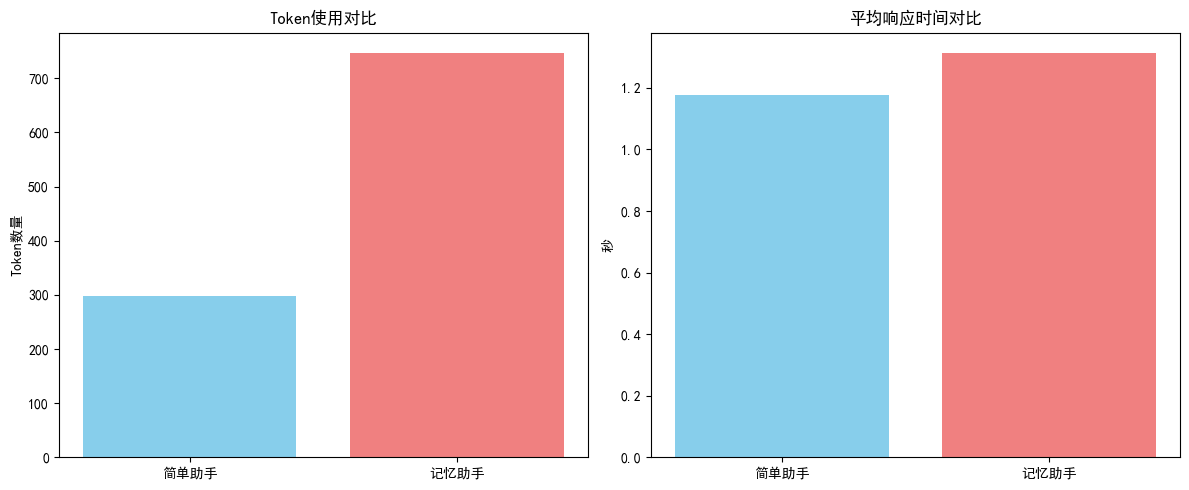

In [45]:
# 对比两种助手的性能

# 导入pandas库，并指定别名pd，用于数据分析与表格处理
import pandas as pd  # pandas是一个常用的数据分析库，pd是其国际惯用别名

# 导入matplotlib.pyplot库，并指定别名plt，用于数据可视化
import matplotlib.pyplot as plt  # plt是matplotlib.pyplot的推荐别名，用于画图

# 计算简单助手使用的总token数
# sum()用于求和；r.get("tokens_used", 0)获取每个结果中的token数量，若无则为0
# 列表推导式用于遍历results中每个元素r，满足"tokens_used"键存在才累加
simple_total_tokens = sum(r.get("tokens_used", 0) for r in results if "tokens_used" in r)

# 计算记忆助手使用的总token数，语法等同于上面，只是遍历memory_results
memory_total_tokens = sum(r.get("tokens_used", 0) for r in memory_results if "tokens_used" in r)

# 计算简单助手的平均响应时间
# sum()把所有响应时间加起来，再除以results的长度，即可得平均值
simple_avg_time = sum(r.get("response_time", 0) for r in results if "response_time" in r) / len(results)

# 计算记忆助手的平均响应时间，语法与上面类似
memory_avg_time = sum(r.get("response_time", 0) for r in memory_results if "response_time" in r) / len(memory_results)

# 构建对比分析的数据字典，key为栏名称，value为数据列表
# "指标"列为分析指标名称；"简单助手"与"记忆助手"为两种助手的数据对比
# f"{simple_avg_time:.2f}秒"：格式化保留两位小数，表示秒；其它内容为字符串描述
comparison_data = {
    "指标": ["总Token使用", "平均响应时间", "记忆能力", "对话连贯性"],
    "简单助手": [simple_total_tokens, f"{simple_avg_time:.2f}秒", "无", "低"],
    "记忆助手": [memory_total_tokens, f"{memory_avg_time:.2f}秒", "有(滑动窗口)", "高"]
}

# 用pandas的DataFrame结构将数据字典转换成表格
df = pd.DataFrame(comparison_data)  # DataFrame是二维表格数据结构

# 打印分隔线与表头
print("📊 两种助手对比分析:")

# 表格以字符串方式打印，index=False表示不显示行索引
print(df.to_string(index=False))

# --- 以下为可视化部分 ---

# 使用matplotlib的subplots方法生成1行2列的子图，figsize设置整个画布大小(宽12, 高5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --------- 左图：Token使用对比 ---------
# 绘制柱状图bar，第一个参数为x轴标签，第二个参数为y值，color列表分别为两种颜色
ax1.bar(["简单助手", "记忆助手"], [simple_total_tokens, memory_total_tokens], color=['skyblue', 'lightcoral'])

# 设置图表标题
ax1.set_title("Token使用对比")

# 设置y轴文本
ax1.set_ylabel("Token数量")

# --------- 右图：平均响应时间对比 ---------
# 画柱状图，x为助手类型，y为平均响应时间
ax2.bar(["简单助手", "记忆助手"], [simple_avg_time, memory_avg_time], color=['skyblue', 'lightcoral'])

# 设置图表标题
ax2.set_title("平均响应时间对比")

# 设置y轴为秒单位
ax2.set_ylabel("秒")

# 调整整体排版，使各子图布局紧凑不重叠
plt.tight_layout()

# 展示图形窗口
plt.show()

In [ ]:
# 安装必要包（如未安装可取消注释）
# !pip install openai python-dotenv

import os
import dotenv
from openai import OpenAI
import json
from datetime import datetime

# 加载.env文件中的环境变量
dotenv.load_dotenv()

# 获取环境变量
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")
model = (
    os.getenv("MODEL_NAME")
    or os.getenv("OPENAI_MODEL")
    or "gpt-3.5-turbo"
)

print("🔍 检查环境配置...\n")
if api_key:
    print("API Key: ✅ 已配置")
else:
    print("API Key: ❌ 未配置，请在.env中填写 OPENAI_API_KEY")

print(f"Base URL: {base_url or 'https://api.openai.com/v1'}")
print(f"Model: {model}")


🔍 检查环境配置...

API Key: ✅ 已配置
Base URL: https://api.chatanywhere.tech/v1
Model: gpt-3.5-turbo


## 🧪 实验时间：探索不同参数

### 实验1：不同窗口大小的影响

In [ ]:
# 测试不同窗口大小的效果
window_sizes = [2, 5, 8]
long_conversation = [
    "我叫张三，是一名医生",
    "我住在北京海淀区",
    "我的爱好是摄影和读书",
    "我有一个猫叫小花",
    "我在协和医院工作",
    "请问，我叫什么名字？",
    "我住在哪里？",
    "我的职业是什么？",
    "我的宠物叫什么名字？"
]

print("🔍 实验不同窗口大小的记忆效果")
print("=" * 60)

for window_size in window_sizes:
    print(f"\n📏 窗口大小: {window_size}")
    print("-" * 40)
    
    agent = MemoryChatAgent(window_size=window_size)
    
    # 只测试关键问题
    key_questions = long_conversation[:5] + long_conversation[5:]  # 所有问题
    
    for i, question in enumerate(key_questions):
        result = agent.chat(question)
        
        # 如果是测试记忆的问题，检查答案质量
        if "名字" in question or "住" in question or "职业" in question or "宠物" in question:
            stats = agent.memory.get_stats()
            print(f"  🧠 当前记忆消息数: {stats['total_messages']}")
        
        print()
        
    if len(key_questions) < 9:
        print("  (完整对话序列已省略，仅展示测试问题)")
    
    print("=" * 40)

🔍 实验不同窗口大小的记忆效果

📏 窗口大小: 2
----------------------------------------

--- 对话 #1 ---
用户: 我叫张三，是一名医生
助手: 你好，张三！很高兴认识你。作为医生，你一定有很多有趣的经历和故事吧？如果你愿意，可以分享一些。
📊 Token使用: 73, 响应时间: 1.64秒
🧠 记忆状态: 3条消息, 窗口大小: 2


--- 对话 #2 ---
用户: 我住在北京海淀区
助手: 北京海淀区是个很不错的地方，既有丰富的文化底蕴，又有许多高等院校和科研机构。你在那里的生活怎么样？有没有推荐的地方或者活动？
📊 Token使用: 135, 响应时间: 1.70秒
🧠 记忆状态: 5条消息, 窗口大小: 2
  🧠 当前记忆消息数: 5


--- 对话 #3 ---
用户: 我的爱好是摄影和读书
助手: 摄影和读书都是很棒的爱好！你喜欢拍摄什么类型的照片？还有你最近在读什么书呢？
📊 Token使用: 131, 响应时间: 1.68秒
🧠 记忆状态: 5条消息, 窗口大小: 2


--- 对话 #4 ---
用户: 我有一个猫叫小花


### 实验2：Temperature参数的影响

In [ ]:
# 测试不同temperature对回复的影响
class CustomSimpleAgent:
    """可自定义参数的简单助手"""
    def __init__(self):
        self.client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),
            base_url=os.getenv("OPENAI_BASE_URL")
        )
    
    def chat(self, message, temperature=0.3):
        response = self.client.chat.completions.create(
            model=os.getenv("MODEL_NAME", "qwen-max"),
            messages=[
                {"role": "system", "content": "你是一个创意助手"},
                {"role": "user", "content": message}
            ],
            temperature=temperature,
            max_tokens=200
        )
        return response.choices[0].message.content

custom_agent = CustomSimpleAgent()
test_creative_question = "请用一句话描述一个充满想象力的未来世界"

temperatures = [0.1, 0.5, 1.0, 1.5]

print("🎨 测试不同Temperature的创意回复")
print("=" * 50)

for temp in temperatures:
    print(f"\n🌡️ Temperature: {temp}")
    response = custom_agent.chat(test_creative_question, temperature=temp)
    print(f"回复: {response}")
    print("-" * 30)

## 💭 互动实验区

In [ ]:
# 在这个区域自由实验！
# 你可以：
# 1. 创建不同参数的记忆助手
# 2. 测试不同的对话策略
# 3. 实验不同的系统提示词

# 示例：创建一个专业助手
professional_agent = MemoryChatAgent(window_size=3)

# 修改系统提示词
professional_agent.memory.context[0] = {
    "role": "system", 
    "content": "你是一个专业的AI顾问，用简洁、专业的语言回答问题。"
}

print("💼 专业助手测试")
print(professional_agent.chat("什么是机器学习？"))
print(professional_agent.chat("可以举一个实际应用例子吗？"))

# 在下面添加你自己的实验...
# print(your_agent.chat("你的问题"))

## 📚 学习总结

### 🎯 关键收获

1. **Agent基础架构**：理解了感知→决策→执行→反馈的闭环
2. **LLM API调用**：掌握了基础的对话实现
3. **记忆管理的重要性**：认识到记忆是Agent的核心能力
4. **滑动窗口策略**：学会了平衡记忆完整性和Token成本

### 🔧 参数调优经验

- **window_size**: 小窗口节省Token但可能丢失重要信息
- **temperature**: 低温度稳定但缺乏创意，高温度创意强但可能不稳定
- **max_tokens**: 控制回复长度，平衡信息量和成本

### 🤔 思考问题

1. 滑动窗口策略的优缺点是什么？
2. 还有哪些更好的记忆管理策略？
3. 如何在长对话中保持关键信息不丢失？

### 🚀 下一步预告

完成第一阶段后，你将进入：
- **第二阶段**：工具调用 - 让Agent能调用外部API
- **第三阶段**：RAG检索 - 给Agent添加知识库
- **第四阶段**：完整系统 - 构建多工具智能助手

恭喜你完成第一阶段学习！🎉